## Projects:

- Diffusion Models;
- YOLO versions  - object detection;
- Segment Anything Model (https://segment-anything.com/) (Liked);
- Mathematical Integration;
- BERT fine-tuning - Text classification (compare with logistic regression and TF-IDF vectors);
- CNN visualization - review the different techniques used to analyze CNN predictions;
- Monte Carlo dropout - review briefly the concept of uncertainty and what are the main techniques used to deal with uncertainty in deep learning;
- Deep vs Wide Neural Networks - Try to understand the effect of adding layers or adding parameters in a layer;
- Overparameterization regime;
- Neural ODEs - Neural Networks and ordinary differential equations are the two main modelization techniques used nowadays, review papers explaining some evolution of the idea of Neural ODE.

General observations:

- Presentation of 15 min 
- 70% grade
- No need to submit the code

Evaluation aspects:

- Clarity
- Understanding of concepts
- Depth of research and/or experiments

In [7]:
import torch
import numpy as np
#import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)
print("✅ SAM Model loaded successfully!")



✅ SAM Model loaded successfully!


To train a CNN for tumor classification (benign, malignant, normal), we will:

Prepare the dataset by splitting images into training (80%) and validation (20%).
Use a CNN architecture  
Train the model using TensorFlow

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import glob

# Define dataset paths
dataset_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Tumors"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Split dataset into train (80%) and validation (20%) if not already done
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for category in ["benign", "malignant", "normal"]:
        images = glob.glob(os.path.join(dataset_dir, category, "*.png"))
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        for img in train_images:
            shutil.copy(img, os.path.join(train_dir, category, os.path.basename(img)))
        for img in val_images:
            shutil.copy(img, os.path.join(val_dir, category, os.path.basename(img)))

# Image preprocessing
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Define CNN model (similar to your example)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same",
                                 input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))  # 3 classes: benign, malignant, normal

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Found 974 images belonging to 3 classes.
Found 245 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32,

I use 5 epochs to see if it works for the moment, we should do 20

Epoch 1/5
31/31 [==============================] - 16s 511ms/step - loss: 0.4337 - accuracy: 0.8255 - val_loss: 0.3613 - val_accuracy: 0.8857
Epoch 2/5
31/31 [==============================] - 15s 489ms/step - loss: 0.3750 - accuracy: 0.8645 - val_loss: 0.3628 - val_accuracy: 0.8898
Epoch 3/5
31/31 [==============================] - 15s 471ms/step - loss: 0.2927 - accuracy: 0.8912 - val_loss: 0.2861 - val_accuracy: 0.9143
Epoch 4/5
31/31 [==============================] - 15s 472ms/step - loss: 0.2674 - accuracy: 0.9097 - val_loss: 0.3150 - val_accuracy: 0.8857
Epoch 5/5
31/31 [==============================] - 15s 489ms/step - loss: 0.2193 - accuracy: 0.9261 - val_loss: 0.4796 - val_accuracy: 0.8898


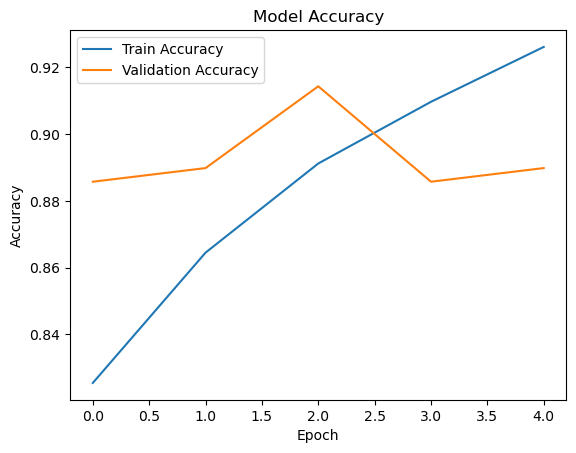

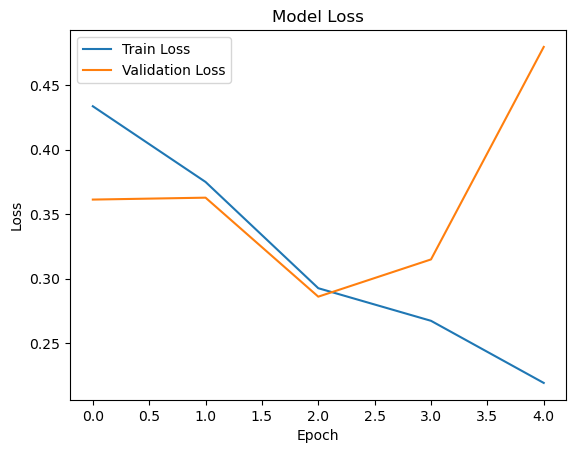

8/8 [==============================] - 2s 186ms/step - loss: 0.4796 - accuracy: 0.8898
Validation Loss: 0.4796
Validation Accuracy: 0.8898


In [11]:

# Train model
epochs = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# Save model
model.save("tumor_classifier.h5")

# Function to plot accuracy
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    plt.show()

# Function to plot loss
def loss_plot(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
    plt.show()

# Plot accuracy and loss
accuracy_plot(history)
loss_plot(history)

# Evaluate model on validation set
score = model.evaluate(val_generator)
print("Validation Loss: {:.4f}".format(score[0]))
print("Validation Accuracy: {:.4f}".format(score[1]))

# Interpreting CNN Training Results

## 1. Key Observations

- **Model is learning well**: Training accuracy steadily increased from 82.55% to 92.61%.
- **Validation accuracy peaked at epoch 3**: 91.43%, then slightly decreased.
- **Validation loss initially decreased but increased at the end**, suggesting possible overfitting.



Question for my boys:

- should we train on the full set of cropped images given that we should test the CNN on the full image vs the SAM segmented images?
- we might have overfitting. stop at Epoch 3? Increase Dropout? Lower the Learning Rate? Add More Data Augmentation eg 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)